In [97]:
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from keras.layers import Reshape
import numpy as np
import helper
from glob import glob
import os
from keras import backend as K
import tensorflow as tf

In [139]:
from keras.models import load_model
AM = load_model('face_gen4k_2.h5')

In [140]:
Gen = AM.get_layer("sequential_1")

## Face 1

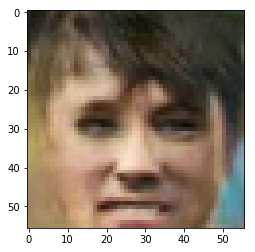

In [143]:
noise = K.random_uniform_variable((1, 400), -1, 1)
i = Gen.predict(noise, steps=1)
im = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(im[0])

## Face 2

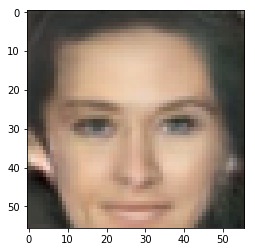

In [144]:
noise2 = K.random_uniform_variable((1, 400), -1, 1)
i2 = Gen.predict(noise2, steps=1)
im2 = (((i2 - i2.min()) * 255) / (i2.max() - i2.min())).astype(np.uint8)
plt.imshow(im2[0])

## Face 1 + Face 2

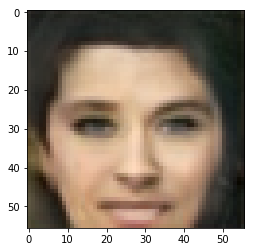

In [145]:
noise3 = (noise + noise2) / 2
i3 = Gen.predict(noise3, steps=1)
im3 = (((i3 - i3.min()) * 255) / (i3.max() - i3.min())).astype(np.uint8)
plt.imshow(im3[0])

## GAN Reverse

In [146]:
def gan_reverse(i, steps = 50):
    #z = K.random_uniform_variable((1, 400), -1, 1)
    z = np.random.uniform(-1.0, 1.0, size = [1, 400])
    x = K.placeholder()
    loss = K.sum(K.square(i - Gen.outputs[0]))
    grad = K.gradients(loss, Gen.inputs[0])[0]
    update_fn = K.function(Gen.inputs, [loss, grad])

    def eval_loss_and_grad(z, j):
        l, g = update_fn([z.reshape(1, 400), j])
        return l.astype('float64'), g.astype('float64')

    for step in range(steps):
        j = Gen.predict(z, steps=1)
        f = lambda x: eval_loss_and_grad(x, j)
        #update_vec = update_fn([z, j])[0]
        #z -= update_vec * 0.005
        z, min_val, _ = fmin_l_bfgs_b(f, z, maxfun=20)
        z = z.reshape(1, 400)
        
        if step % 5 == 0:
            print("Step:", step)
    return z

Step: 0
Step: 5


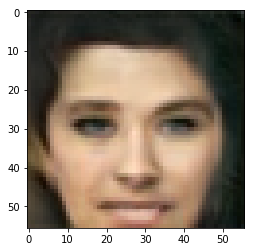

In [147]:
z = gan_reverse(i3, steps=6)
j = Gen.predict(z, steps=1)
j = (((j - j.min()) * 255) / (j.max() - j.min())).astype(np.uint8)
plt.imshow(j[0])

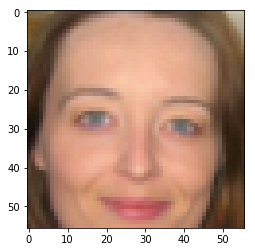

In [164]:
'''
im_dir = glob(os.path.join('.', 'jch.jpeg'))[0]
image1 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56, face_size=80, delta_i=-10, delta_j=0)
plt.imshow(image1)
'''
im_dir = glob(os.path.join('.', 'mabi.jpeg'))[0]
image1 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56, face_size=220, delta_i=-40, delta_j=10)
plt.imshow(image1)


Step: 0
Step: 5
Step: 10
Step: 15


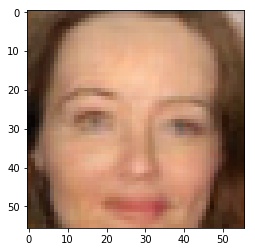

In [165]:
z1 = gan_reverse(image1 / 255 - 0.5, steps = 20)  
j1 = Gen.predict(z1, steps=1)
plt.imshow(helper.image_for_plot(j1[0]))

"\nim_dir = glob(os.path.join('.', 'rno.jpeg'))[0]\nimage2 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56,                          face_size=220, delta_i=-50, delta_j=0)\nplt.imshow(image2)\n"

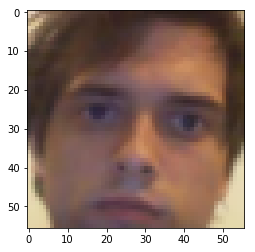

In [168]:

im_dir = glob(os.path.join('.', 'pirog.jpg'))[0]
image2 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56, \
                         face_size=140, delta_i=-20, delta_j=0)
plt.imshow(image2)
'''
im_dir = glob(os.path.join('.', 'rno.jpeg'))[0]
image2 = helper.get_image(im_dir, 'RGB', helper.preprocessing, width=56, height=56, \
                         face_size=220, delta_i=-50, delta_j=0)
plt.imshow(image2)
'''

Step: 0
Step: 5
Step: 10
Step: 15
Step: 20
Step: 25
Step: 30
Step: 35
Step: 40
Step: 45


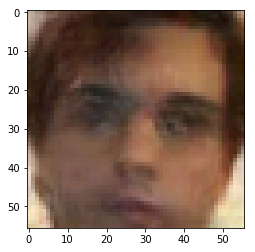

In [172]:
z2 = gan_reverse(image2 / 255 - 0.5, steps = 50)
j2 = Gen.predict(z2, steps=1)
plt.imshow(helper.image_for_plot(j2[0]))

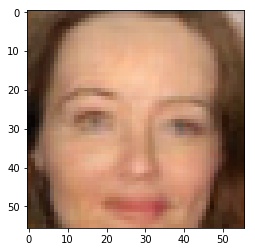

In [166]:
plt.imshow(helper.image_for_plot(j1[0]))

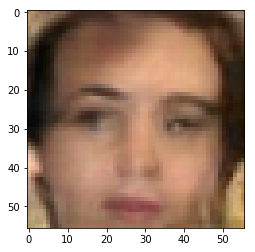

In [171]:
j3 = Gen.predict((z1 + z2) / 2, steps=1)
plt.imshow(helper.image_for_plot(j3[0]))